# Drift correction factor velocity scatter plots

### Notes

- Below, I'm looping through a few different bin count selection methods for exploratory purposes. In the actual drift-tool version, we'll choose one method only (so we won't need get_num_bins() at all in the real version of the code). 


- I'm not sure we should let the number of bins be a customizable parameter at all. If the user is digging deep enough to want to use their own number of bins, they'll probably also be making their own version of the plot, right? 

In [33]:
# only used for the Jupyter Notebook version:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.ticker import MaxNLocator

In [34]:
def concat_datasets(files):
    """ This is only needed outside the GPSC. The actual plot
    will take a dataset as the input and the dataset will be
    created in a different way than this function (with 
    load_dataset() for example)"""
    
    dslist = []
    for fname in files:
        ds = xr.open_dataset(fname)
        dslist.append(ds)
    
    ds = xr.concat(
        dslist,
        pd.Index([ds.obs_buoyid for ds in dslist],
                 name='buoyid')
    )
    
    return ds

In [39]:
def get_num_bins(ds, velocities, bin_method='default'):
    """ a variety of bin count selection methods for exploratory purposes. 
    In the actual drift-tool version of this plot we'll choose one method
    to go with so this function will not likely be used in the real code."""
    # using methods from: 
    # https://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width
        
    sample_size = np.nanmean([len(vel) for vel in velocities])
    
    if bin_method == 'freedman_diaconis':
        def calc_freeman_diaconis(ds):
            q1 = ds.quantile(0.25)
            q3 = ds.quantile(0.75)
            iqr = q3 - q1
            bin_width = (2 * iqr) / (len(ds) ** (1 / 3))
            num_bins = int(np.ceil((ds.max() - ds.min()) / bin_width))
            return num_bins
        numbins = np.nan
        for vel in velocities:
            numbins = int(np.nanmax([calc_scott(vel), numbins]))
        
    elif bin_method == 'scott':
        def calc_scott(ds):
            R = np.nanmax(ds) - np.nanmin(ds)
            std = np.nanstd(ds)
            num_bins = R * (sample_size ** (1/3)) / (3.49 * std)
            num_bins = int(np.ceil(num_bins))
            return num_bins
        numbins = np.nan
        for vel in velocities:
            numbins = int(np.nanmax([calc_scott(vel), numbins]))
     
    elif bin_method == 'sturge':
        numbins = int(np.ceil(np.log2(sample_size)) + 1)

    elif bin_method == 'rice':
        numbins = int(np.ceil(2 * sample_size ** (1/3)))
        
    elif bin_method == 'root':
        numbins = int(np.ceil(np.sqrt(sample_size)))
        
    else:
        numbins = 100
    
    return numbins

    
def get_bin_parameters(velocities, numbins=None, val=None):
    """ Helper function that finds the maximum velocity value between ocean
    and drifter so that it can be used as axis limits when plotting.
    Then, defines the data bins to use for the histogram plots based on
    the maximum velocity value. """

    # calculate the maximum data value if necessary
    if val is None:
        
        alldata = np.concatenate(velocities)
        
        maxval = np.nanmax([np.abs(np.nanmin(alldata)), 
                            np.abs(np.nanmax(alldata))])
        
        # adding a small buffer to keep the data from plotting
        # directly on the edges of the plot
        maxval = maxval + 0.1 * maxval

    # if the number of bins is not given, calculate it too.
    # This won't need to be done in the actual drift-tool code
    # because we'll have a set value
    if numbins is None:
        numbins = get_num_bins(ds, velocities, 'default')
        
    data_bins = np.linspace(-1 * maxval, maxval, num=numbins)
    
    return maxval, data_bins

In [40]:
def velocity_scatter_plots(ds, numbins=100):
    """ Scatter plot of the drifter velocity versus the ocean velocity 
    from a collection of drift correction factor output files 
    
    Parameters
    ----------
    ds : xarray.Dataset
        Xarray dataset containing output data from a drift correction factors
        experiment.
    numbins : int
        Temporary(?) argument specifying the number of bins to use for the 
        2d histogram. This may be removed entirely if we choose not to make 
        this customizable.
    """
    
    fig = plt.figure(figsize=(6, 12), dpi=100)
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(1, 2), 
                     axes_pad=0.2,
                     cbar_mode="single",
                     cbar_location="right",
                     cbar_pad=0.2)
    
    velocities = [np.concatenate(ds.ueast_drifter.values), 
                  np.concatenate(ds.ueast_ocean.values), 
                  np.concatenate(ds.vnorth_drifter.values), 
                  np.concatenate(ds.vnorth_ocean.values)]
    
    val, bins = get_bin_parameters(velocities, numbins=numbins)
          
    for ax, data, title in zip(grid,
                               [[velocities[0], velocities[1]], [velocities[2], velocities[3]]],
                               ['Eastward Component', 'Northward Component']):

        h = ax.hist2d(data[0], data[1], cmin=1, bins=bins)
        
        # add labels and gridlines
        ax.set_xlabel('Drifter Velocity [m/s]')
        ax.set_ylabel('Ocean Velocity [m/s]')
        ax.set_title(title)
        ax.grid(True, linestyle='--', alpha=0.5)

        # adjust the number of tickmarks being displayed on the axis
        locator=MaxNLocator(prune='both', nbins=6, symmetric=True)
        ax.xaxis.set_major_locator(locator)
        ax.yaxis.set_major_locator(locator)

        # add a red dotted line
        ax.axline((float(-1*val), float(-1*val)), 
                  slope=float((val - -1*val) / (val - -1*val)), 
                  color='red', 
                  linewidth=0.6, 
                  linestyle=(0, (5, 5)))

    # add the colorbar
    cbar = fig.colorbar(h[3], cax=grid.cbar_axes[0], orientation='vertical')
    cbar.set_label('Counts per bin')
    
    ######################################
    # Tidy up the plot then save:
    ######################################
    outname = 'velocity_scatter_plots_' + str(numbins) + 'bins'
    fig.savefig(
        os.path.join(plotdir, (outname + '.png')),
        bbox_inches='tight',
        dpi=300
    )
    plt.show()
    plt.close()
    

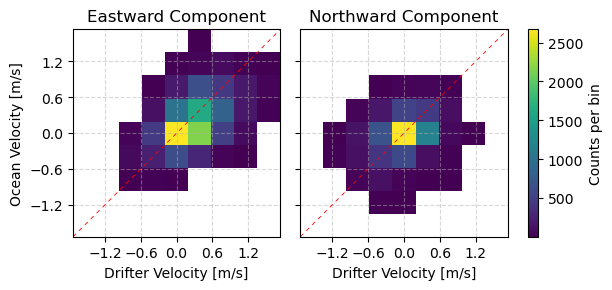

In [41]:
datadir = "C:/Users/HoldenJe/Drift/projects/DriftCorrectionFactor/DCF_velocity_error_plots/sample_input_files/"
plotdir = "C:/Users/HoldenJe/Drift/projects/DriftCorrectionFactor/DCF_velocity_error_plots/output_plots/"

files = glob.glob(os.path.join(datadir, '*.nc'))
files.sort()

# this is only temporary for Jupyter Notebook purposes:
ds = concat_datasets(files)

# Using numbins = 10 because this is the default value for 2dhist. 
# We can (and should!) pick something different though. We can also 
# add whatever we pick directly into the function instead of including
# the numbins argument:
velocity_scatter_plots(ds, numbins=10)



sturge (14 bins)



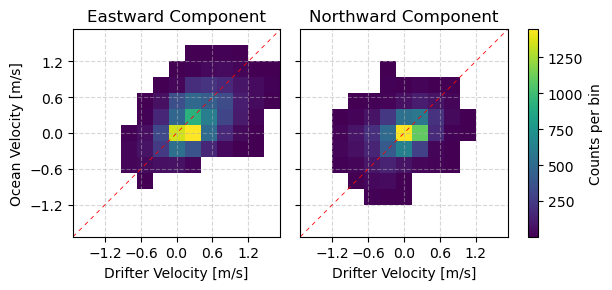



rice (40 bins)





root (88 bins)



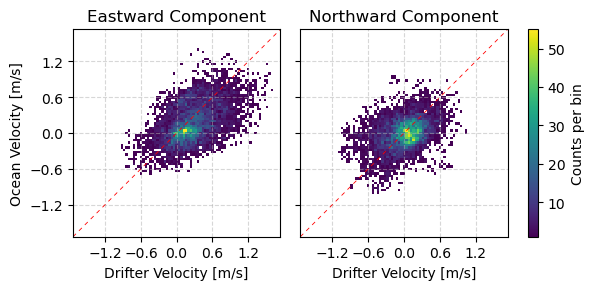



default (100 bins)



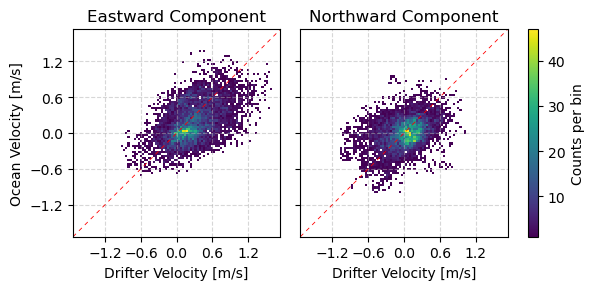



scott (45 bins)



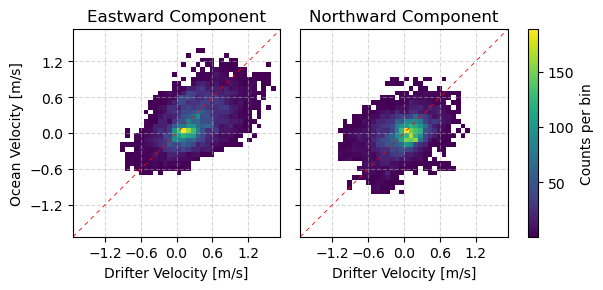



freedman-diaconis (100 bins)



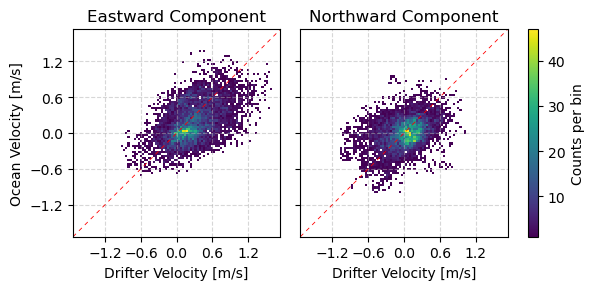

In [42]:
# for exploration:

datadir = "C:/Users/HoldenJe/Drift/projects/DriftCorrectionFactor/DCF_velocity_error_plots/sample_input_files/"
plotdir = "C:/Users/HoldenJe/Drift/projects/DriftCorrectionFactor/DCF_velocity_error_plots/output_plots/"

files = glob.glob(os.path.join(datadir, '*.nc'))
files.sort()

# this is only temporary for Jupyter Notebook purposes:
ds = concat_datasets(files)

# this is only temporary for exploring the bin calculation methods:
velocities = [np.concatenate(ds.ueast_drifter.values), 
              np.concatenate(ds.ueast_ocean.values), 
              np.concatenate(ds.vnorth_drifter.values), 
              np.concatenate(ds.vnorth_ocean.values)]

methods = ['sturge', 'rice', 'root', 'default', 'scott', 'freedman-diaconis']
for method in methods:
    numbins = get_num_bins(ds, velocities, bin_method=method)
    print('\n\n' + str(method) + ' (' + str(numbins) + ' bins)\n')
    
    # This is the only part that's really necessary here and will
    # probably eventually just read as velocity_scatter_plots(ds):
    velocity_scatter_plots(ds, numbins=numbins)